# Fish weight prediciton using Regression Analysis 
- Building an ML Regression Model Using the Tree-based Algorithms (Decision Tree, Random Forest, XGboost)

### 1. Importing libraries and collecting data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
data = pd.read_csv("~\Fish.csv")

### 2. Visualizing the dataset

In [2]:
data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
data.tail()

,Species,Weight,Length1,Length2,Length3,Height,Width
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672
158,Smelt,19.9,13.8,15.0,16.2,2.9322,1.8792


In [4]:
data.shape

(159, 7)

In [5]:
data.isnull().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

- no null values in our dataset so we can proceed further 

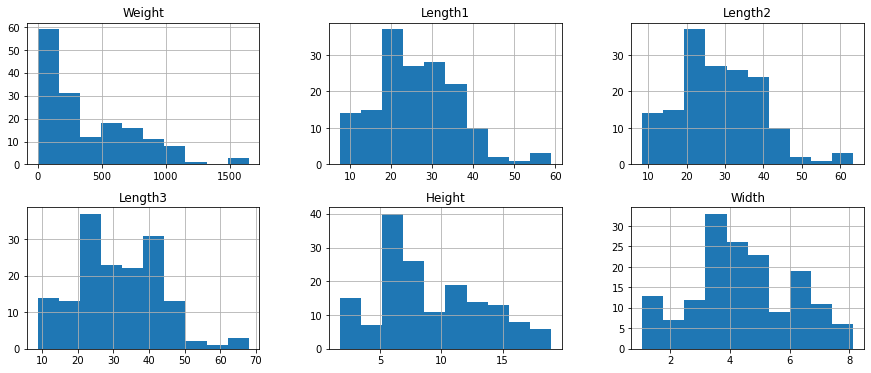

In [6]:
data_num = data.drop(columns=["Species"])

fig, axes = plt.subplots(len(data_num.columns)//3, 3, figsize=(15, 6))
i = 0
for triaxis in axes:
    for axis in triaxis:
        data_num.hist(column = data_num.columns[i], ax=axis)
        i = i+1

This shows the distribution among the numerical features in dataset

#### Let's check the distribution of target variable(weight) with respect to fish's species

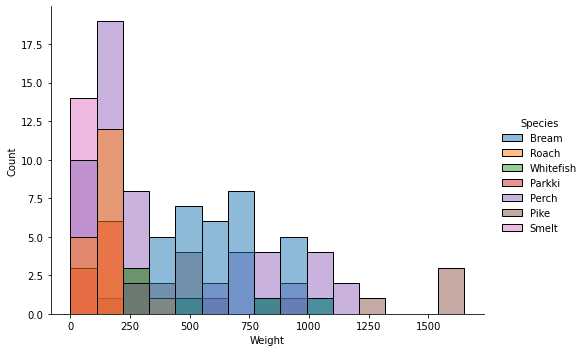

In [7]:
sns.displot(
    data=data,
    x = "Weight",
    hue = "Species",
    kind = "hist",
    height = 5,
    aspect = 1.4,
    bins = 15
)
plt.show()

Target variable distribution of weight with respect to species shows that there are some species such as Pike that have huge weight compared to others. This visualization gives us additional information on how the “species” feature can be used for prediction.

### 3. Cleaning of data

In [8]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
data_cleaned  = data.drop("Weight", axis=1)
y = data['Weight']

x_train, x_test, y_train, y_test = train_test_split(data_cleaned, y, test_size = 0.2,
                                                   random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# label encoder
label_encoder = LabelEncoder()
x_train['Species'] = label_encoder.fit_transform(x_train['Species'].values)
x_test['Species'] = label_encoder.transform(x_test['Species'].values)

(127, 6) (32, 6) (127,) (32,)


### 4. Training all 3 models

In [10]:
def evaluation_model(pred, y_val):
  score_MSE = round(mean_squared_error(pred, y_val),2)
  score_MAE = round(mean_absolute_error(pred, y_val),2)
  score_r2score = round(r2_score(pred, y_val),2)
  return score_MSE, score_MAE, score_r2score
def models_score(model_name, train_data, y_train, val_data,y_val):
    model_list = ["Decision_Tree","Random_Forest","XGboost_Regressor"]
    #model_1
    if model_name=="Decision_Tree":
        reg = DecisionTreeRegressor(random_state=42)
    #model_2
    elif model_name=="Random_Forest":
      reg = RandomForestRegressor(random_state=42)
        
    #model_3
    elif model_name=="XGboost_Regressor":
        reg = xgb.XGBRegressor(objective="reg:squarederror",random_state=42,)
    else:
        print("please enter correct regressor name")
        
    if model_name in model_list:
        reg.fit(train_data,y_train)
        pred = reg.predict(val_data)
     
        score_MSE, score_MAE, score_r2score = evaluation_model(pred,y_val)
        return round(score_MSE,2), round(score_MAE,2), round(score_r2score,2)
model_list = ["Decision_Tree","Random_Forest","XGboost_Regressor"]
result_scores = []
for model in model_list:
    score = models_score(model, x_train, y_train, x_test, y_test)
    result_scores.append((model, score[0], score[1],score[2]))
    print(model,score)

Decision_Tree (7005.89, 48.71, 0.95)
Random_Forest (4659.44, 44.66, 0.97)
XGboost_Regressor (5151.54, 41.05, 0.96)


### 5. Displaying the scores

In [11]:
df_result_scores = pd.DataFrame(result_scores,columns = ["model","mse","mae", "r2_score"])
df_result_scores

,model,mse,mae,r2_score
0,Decision_Tree,7005.89,48.71,0.95
1,Random_Forest,4659.44,44.66,0.97
2,XGboost_Regressor,5151.54,41.05,0.96


##### The results shows a very different result than linear models. The values of mse and mae are very low as compared to linear based models. This shows that all tree-based models are better than linear models in this type of dataset

 ### 6. Hyperparameter tuning

In [12]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [13]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.model_selection import cross_val_score
num_estimator = [100,150,200,250]

space=  {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 30,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice("n_estimators", num_estimator),
    }

def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators = space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']) , min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'], objective="reg:squarederror")
    
    score_cv = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
    return {'loss':-score_cv, 'status': STATUS_OK, 'model': model}


trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)

print(best)

100%|████████████████████████████████████████████████| 200/200 [01:56<00:00,  1.71trial/s, best loss: 38.1540564471905]
{'colsample_bytree': 0.8203687214298399, 'gamma': 2.770082660001186, 'max_depth': 12.0, 'min_child_weight': 1.0, 'n_estimators': 2, 'reg_alpha': 43.0, 'reg_lambda': 0.6364003313436989}


In [25]:
trials.results[0:2]

[{'loss': 52.191508596684386,
  'status': 'ok',
  'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.519490129605568, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=7.189562594538164, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
               max_leaves=None, min_child_weight=4.0, missing=nan,
               monotone_constraints=None, n_estimators=250, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None, ...)},
 {'loss': 46.35706025637113,
  'status': 'ok',
  'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None

In [27]:
reg = xgb.XGBRegressor(**best)
reg.fit(x_train,y_train)
pred = reg.predict(x_test)
score_MSE, score_MAE, score_r2score = evaluation_model(pred,y_test) 
to_append = ["XGboost_hyper_tuned",score_MSE, score_MAE, score_r2score]
df_result_scores.loc[len(df_result_scores)] = to_append
df_result_scores

,model,mse,mae,r2_score
0,Decision_Tree,7005.89,48.71,0.95
1,Random_Forest,4659.44,44.66,0.97
2,XGboost_Regressor,5151.54,41.05,0.96
3,XGboost_hyper_tuned,2755.94,36.02,0.98


There is a huge difference in mse and mae scores of XGboost_hyper_tuned model even if compared with the best linear based model. This shows that tree based models should be preferable as compared to linear based models when working with this kind of databases

### 7. Chossing the best model and making prediction

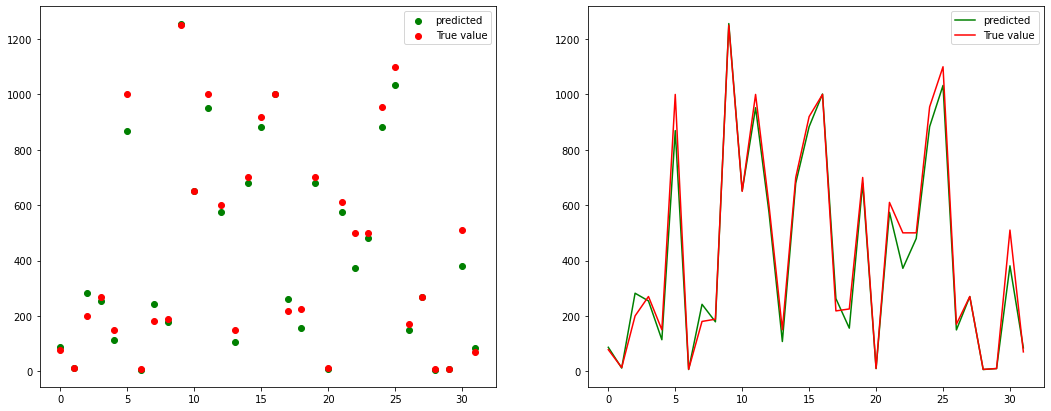

In [17]:
reg = xgb.XGBRegressor(**best)
reg.fit(x_train,y_train)
pred = reg.predict(x_test)
plt.figure(figsize=(18,7))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.scatter(range(0,len(x_test)), pred,color="green",label="predicted")
plt.scatter(range(0,len(x_test)), y_test,color="red",label="True value")
plt.legend()

plt.subplot(1, 2, 2) # index 2
plt.plot(range(0,len(x_test)), pred,color="green",label="predicted")
plt.plot(range(0,len(x_test)), y_test,color="red",label="True value")
plt.legend()
plt.show()

##### The predicition is quite accurate as the true values are not far enough with our predicted values. This concludes our prediction model.